In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount("./content")

Mounted at ./content


In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def evaluate(model, test_dl, crit):
  total = 0
  correct = 0
  tot_loss = 0
  model.eval()
  for x, y in test_dl:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    l = crit(o,y)
    tot_loss += l.item()
    correct += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  test_loss = tot_loss / len(test_dl)
  test_acc = 100 * correct / total
  return test_loss, test_acc

def train_one_epoch(model, train_dl, crit, optim):
  total = 0
  correct = 0
  tot_loss = 0
  model.train()
  for x, y in train_dl:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    l = crit(o,y)
    l.backward()
    optim.step()
    tot_loss += l.item()
    correct += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  train_loss = tot_loss / len(train_dl)
  train_acc = 100 * correct / total
  return train_loss, train_acc

def train(model, train_dl, test_dl, crit, optim, lr_sched=None, epochs=10, checkpoint=0):
  for epoch in tqdm.tqdm_notebook(range(epochs)):
    train_loss, train_acc = train_one_epoch(model, train_dl, crit, optim)
    test_loss, test_acc = evaluate(model, test_dl, crit)
    if lr_sched is not None:
      lr_sched.step()
    if checkpoint>0 and epoch % checkpoint == 0:
      torch.save(model.state_dict(),f"checkpoint_{epoch}.ckpt")
    print(f"epoch: {epoch}, train loss: {train_loss}, train accuracy: {train_acc:.2f}%, test loss: {test_loss}, test accuracy: {test_acc:.2f}%")

In [ ]:
def make_simple_conv_block(in_planes, out_planes, kernel_size=3):
  return nn.Sequential(
      nn.Conv2d(in_planes, out_planes, kernel_size, bias=False),
      nn.BatchNorm2d(out_planes),
      nn.ReLU(inplace=True)
  )

In [ ]:
train_ds = torchvision.datasets.MNIST("./content/MyDrive/MachineLearning/datasets/",train=True,transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.MNIST("./content/MyDrive/MachineLearning/datasets/",train=False,transform=torchvision.transforms.ToTensor())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128)

In [ ]:
model = nn.Sequential(
    make_simple_conv_block(1,16),
    nn.MaxPool2d(2),
    make_simple_conv_block(16,32),
    make_simple_conv_block(32,64),
    nn.MaxPool2d(2),
    make_simple_conv_block(64,128),
    nn.Flatten(),
    nn.Linear(512,10)
).to(dev)

In [ ]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1)
lr_sched = torch.optim.lr_scheduler.StepLR(optim, step_size=5,gamma=0.2)
train(model, train_dl, test_dl, crit, optim, lr_sched=lr_sched, epochs=15,checkpoint=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

epoch: 0, train loss: 0.11069880760456524, train accuracy: 97.16%, test loss: 0.06676004472471585, test accuracy: 98.01%
epoch: 1, train loss: 0.03530439270597233, train accuracy: 99.03%, test loss: 0.03875949997138055, test accuracy: 98.73%
epoch: 2, train loss: 0.023062877093582276, train accuracy: 99.40%, test loss: 0.03284458403642838, test accuracy: 98.91%
epoch: 3, train loss: 0.01599102328484406, train accuracy: 99.64%, test loss: 0.0280910217703491, test accuracy: 99.00%
epoch: 4, train loss: 0.011140111788572656, train accuracy: 99.81%, test loss: 0.028666999420192376, test accuracy: 99.06%
epoch: 5, train loss: 0.007252151945862534, train accuracy: 99.90%, test loss: 0.020685135767628628, test accuracy: 99.35%
epoch: 6, train loss: 0.005988987450799925, train accuracy: 99.94%, test loss: 0.020427870886883685, test accuracy: 99.35%
epoch: 7, train loss: 0.005388801759751791, train accuracy: 99.95%, test loss: 0.020379542411020236, test accuracy: 99.35%
epoch: 8, train loss: 0.

In [ ]:
def get_directions():
  params = []
  for i in range(15):
    tmp_ = torch.load(f"checkpoint_{i}.ckpt",map_location=torch.device("cpu"))
    params_ = []
    for k,v in tmp_.items():
      if "tracked" in k or "running" in k:
        continue
      params_.append(v.detach().clone().numpy().reshape(-1))
    params.append(params_)
  directions1 = []
  directions2 = []
  for i in range(len(params[0])):
    tmp = []
    for j in range(15):
      tmp.append(params[j][i])
    tmp = np.array(tmp)
    pca = PCA(n_components=2)
    pca.fit_transform(tmp)
    directions1.append(pca.components_[0])
    directions2.append(pca.components_[1])
  return directions1, directions2

In [ ]:
def get_base_model(path):
  params = []
  for k,v in torch.load(path,map_location=torch.device("cpu")).items():
    if "tracked" in k or "running" in k:
      continue
    params.append(v.detach().clone().numpy().reshape(-1))
  return params

In [ ]:
directions1, directions2 = get_directions()

In [ ]:
base_params = get_base_model("checkpoint_14.ckpt")

In [ ]:
def get_landscape(base_model, base_params, directions1, directions2,test_dl, crit, x=np.linspace(-5,5,10),y=np.linspace(-5,5,10)):
  loss_ = []
  for x_ in x:
    for y_ in y:
      for i, param in enumerate(model.parameters()):
        param.data = torch.from_numpy(base_params[i] + x_ * directions1[i] + y_ * directions2[i]).reshape(param.shape).to(dev)
      test_loss, test_acc = evaluate(base_model, test_dl, crit)
      loss_.append(test_loss)
  loss_ = np.array(loss_)
  loss_ = loss_.reshape((len(x),len(y)))
  return loss_

In [ ]:
crit = nn.CrossEntropyLoss()
x = np.linspace(-2,2,10)
y = np.linspace(-2,2,10)
X, Y = np.meshgrid(x,y)
Z = get_landscape(model, base_params, directions1, directions2, test_dl,crit,x=x,y=y)

In [ ]:
Z

array([[5.33839545e+01, 3.11709369e+01, 2.19743521e+01, 1.92199357e+01,
        2.19806893e+01, 3.82592458e+01, 5.98506645e+01, 8.51475949e+01,
        1.10290102e+02, 1.37241217e+02],
       [5.16147387e+01, 2.48386033e+01, 1.50563530e+01, 1.31137403e+01,
        1.01326368e+01, 1.83154861e+01, 3.24056320e+01, 4.81998344e+01,
        6.51581962e+01, 8.44841439e+01],
       [5.02043703e+01, 2.44357022e+01, 1.17248833e+01, 8.80903118e+00,
        4.29748433e+00, 7.81923631e+00, 1.69494793e+01, 2.67830287e+01,
        3.84027407e+01, 5.50840078e+01],
       [4.41888818e+01, 2.19637178e+01, 9.09159063e+00, 5.36840978e+00,
        1.09372508e+00, 1.93019103e+00, 8.43908907e+00, 1.48376154e+01,
        2.38136118e+01, 3.88982473e+01],
       [3.64603802e+01, 1.83456417e+01, 7.70446952e+00, 3.46644649e+00,
        2.33671693e-01, 1.26824169e-01, 2.87571343e+00, 7.76283976e+00,
        1.52657600e+01, 2.83143897e+01],
       [3.09517657e+01, 1.59665621e+01, 7.87461727e+00, 3.80429094e+00,
   

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


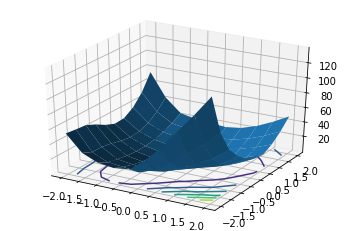

In [ ]:
fig, axs = plt.subplots(1,1, subplot_kw={"projection": "3d"})
axs.plot_surface(X,Y,Z)
axs.contour(X,Y,Z,offset=0)